# Synthetic experiments

Note that this notebook requires the Python library [causally](https://causally.readthedocs.io/en/latest/).

In [28]:
import numpy as np
import causally.graph.random_graph as rg
import causally.scm.noise as noise
from utils import *
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Generate simple linear graph (no confounders).

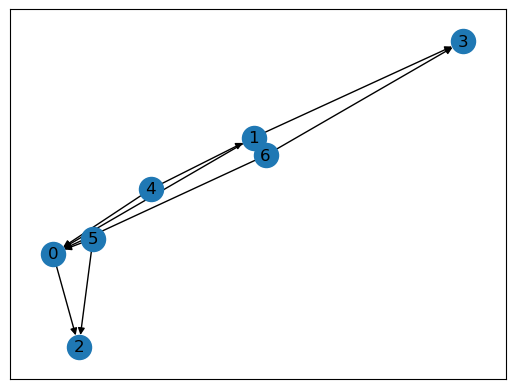

In [29]:
adjacency = np.array([[0,0,1,0,0,0,0], # label
                      [1,0,0,1,0,0,0], # causal feature
                      [0,0,0,0,0,0,0], # anti-causal feature
                      [0,0,0,0,0,0,0], # spurious feature
                      [1,1,0,0,0,0,0], # potential confounder of label and causal feature
                      [1,0,1,0,0,0,0], # potential confounder of label and anti-causal feature
                      [1,0,0,1,0,0,0], # potential confounder of label and spurios feature
                      ])

graph_generator = rg.CustomGraph(
   adjacency=adjacency
)
rg.graph_viz(adjacency)

# Generator of the normal distributed noise terms
noise_generator = noise.Normal()
# noise_generator = noise.MLPNoise()

# Generated the data
num_samples=1000
    
# causal_mechanism = LinearMechanism()
causal_mechanism = NeuralNetMechanism()

Generate training samples

In [30]:
train_dataset = generate_train_samples(num_samples, adjacency, causal_mechanism, noise_generator)
train_labels = get_labels(train_dataset)
train_features = get_features(train_dataset)

In [31]:
causal_mechanism.transformations[0]

Sequential(
  (0): Linear(in_features=4, out_features=10, bias=True)
  (1): PReLU(num_parameters=1)
  (2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (3): Linear(in_features=10, out_features=1, bias=True)
)

Generate in-domain testing samples

In [32]:
id_test_dataset = generate_train_samples(num_samples, adjacency, causal_mechanism, noise_generator)
id_test_labels = get_labels(id_test_dataset)
id_test_features = get_features(id_test_dataset)

In [33]:
causal_mechanism.transformations[0]

Sequential(
  (0): Linear(in_features=4, out_features=10, bias=True)
  (1): PReLU(num_parameters=1)
  (2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (3): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
constant = DummyClassifier(strategy="most_frequent")
constant.fit(train_features,train_labels)
id_test_pred = constant.predict(id_test_features)
id_accuracy = accuracy_score(id_test_labels, id_test_pred)
id_accuracy

0.562

Text(0.5, 1.0, 'Label shift between training and in-domain testing')

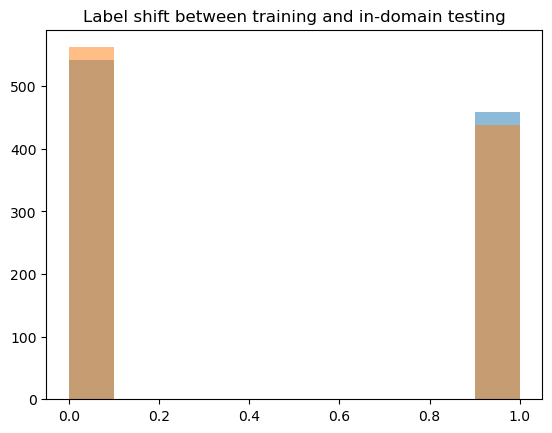

In [35]:
plt.hist(train_labels,alpha=0.5)

plt.hist(id_test_labels,color="tab:orange",alpha=0.5)
plt.title("Label shift between training and in-domain testing")

In [36]:
# Fit the model with causal feature
logistic_causal = MLPClassifier()
logistic_causal.fit(train_features[:,0].reshape(-1, 1),train_labels)
id_test_pred = logistic_causal.predict(id_test_features[:,0].reshape(-1, 1))
causal_id_accuracy = accuracy_score(id_test_labels, id_test_pred)
causal_id_accuracy


0.6

In [37]:
# Fit model with causal and anti-causal feature
logistic_causal_anticausal = MLPClassifier()
logistic_causal_anticausal.fit(train_features[:,:2],train_labels)
id_test_pred = logistic_causal_anticausal.predict(id_test_features[:,:2])
causal_anticausal_id_accuracy = accuracy_score(id_test_labels, id_test_pred)
causal_anticausal_id_accuracy

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.889

In [38]:
# Fit model with all features
logistic_all = MLPClassifier()
logistic_all.fit(train_features,train_labels)
id_test_pred = logistic_all.predict(id_test_features)
all_id_accuracy = accuracy_score(id_test_labels, id_test_pred)
all_id_accuracy


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.889

## Covariate shift

Generate synthetic experiments with different degree of covariate shift

In [39]:
def generate_ood(ood_accuracy,causal_shift,anti_causal_shift,spurios_shift):

    dataset = generate_test_samples(num_samples, adjacency, causal_mechanism, noise_generator, 
                                shift_interventions={0:0,1:causal_shift,2:anti_causal_shift,3:spurios_shift,4:0,5:0,6:0})
    ood_test_labels = get_labels(dataset)
    ood_test_features = get_features(dataset)


    ood_test_pred = logistic_causal.predict(ood_test_features[:,0].reshape(-1, 1))
    ood_accuracy[round(causal_shift,1)][round(anti_causal_shift,1)][round(spurios_shift,1)]["causal"] = accuracy_score(ood_test_labels, ood_test_pred)

    ood_test_pred = logistic_causal_anticausal.predict(ood_test_features[:,:2])
    ood_accuracy[round(causal_shift,1)][round(anti_causal_shift,1)][round(spurios_shift,1)]["causal_anticausal"] = accuracy_score(ood_test_labels, ood_test_pred)

    ood_test_pred = logistic_all.predict(ood_test_features)
    ood_accuracy[round(causal_shift,1)][round(anti_causal_shift,1)][round(spurios_shift,1)]["all"] = accuracy_score(ood_test_labels, ood_test_pred)

    return ood_accuracy

In [40]:
ood_accuracy = {}
for causal_shift in np.arange(0,10,.1):
    anti_causal_shift = 0
    spurios_shift = 0
    ood_accuracy[round(causal_shift,1)] = {}
    ood_accuracy[round(causal_shift,1)][round(anti_causal_shift,1)] = {}
    ood_accuracy[round(causal_shift,1)][round(anti_causal_shift,1)][round(spurios_shift,1)] = {}
    ood_accuracy = generate_ood(ood_accuracy,causal_shift,anti_causal_shift,spurios_shift)


for anti_causal_shift in np.arange(0,10,.1):
    causal_shift = 0
    spurios_shift = 0
    if anti_causal_shift > 0:
        ood_accuracy[round(causal_shift,1)][round(anti_causal_shift,1)] = {}
        ood_accuracy[round(causal_shift,1)][round(anti_causal_shift,1)][round(spurios_shift,1)] = {}
    ood_accuracy = generate_ood(ood_accuracy,causal_shift,anti_causal_shift,spurios_shift)

for spurios_shift in np.arange(0,10,.1):
    causal_shift = 0
    anti_causal_shift = 0
    if spurios_shift > 0:
        ood_accuracy[round(causal_shift,1)][round(anti_causal_shift,1)][round(spurios_shift,1)] = {}
    ood_accuracy = generate_ood(ood_accuracy,causal_shift,anti_causal_shift,spurios_shift)
            

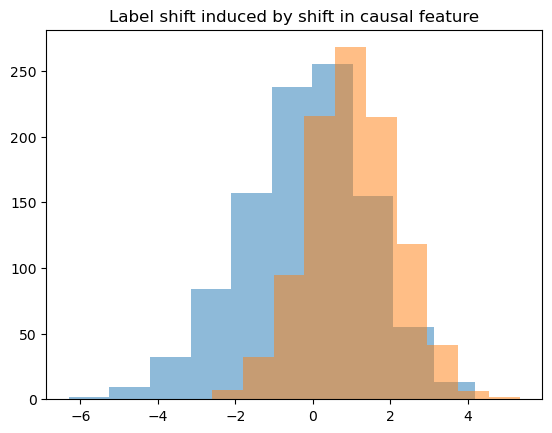

In [41]:
dataset = generate_test_samples(num_samples, adjacency, causal_mechanism, noise_generator, 
                                        shift_interventions={0:0,1:0,2:0,3:0,4:0,5:0,6:0})
labels = get_labels(dataset)
plt.hist(dataset[:,0],alpha=0.5)

dataset = generate_test_samples(num_samples, adjacency, causal_mechanism, noise_generator, 
                                        shift_interventions={0:0,1:10,2:0,3:0,4:0,5:0,6:0})
labels = get_labels(dataset)
plt.hist(dataset[:,0],color="tab:orange",alpha=0.5)
plt.title("Label shift induced by shift in causal feature")
plt.savefig('figures/exp/label_shift_causal.pdf')

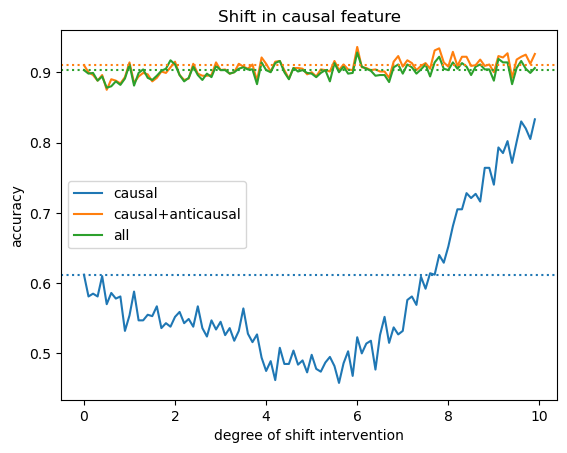

In [42]:
shift = np.arange(0,10,.1)
causal_ood_accuracy = np.array([ood_accuracy[round(item,1)][0][0]["causal"] for item in shift])
# causal_lb = [
#     smp.proportion_confint(count=int(item * num_samples), nobs=num_samples, alpha=0.05, method='beta')[0] for item in causal_ood_accuracy]
# causal_ub = [
#     smp.proportion_confint(count=int(item * num_samples), nobs=num_samples, alpha=0.05, method='beta')[0] for item in causal_ood_accuracy]
causal_anticausal_ood_accuracy = np.array([ood_accuracy[round(item,1)][0][0]["causal_anticausal"] for item in shift])
all_ood_accuracy = np.array([ood_accuracy[round(item,1)][0][0]["all"] for item in shift])
plt.title("Shift in causal feature")
plt.plot(shift,causal_ood_accuracy,label="causal")

# plt.fill_between(shift, causal_lb, causal_ub, alpha=0.5)


plt.plot(shift,causal_anticausal_ood_accuracy, label="causal+anticausal")


plt.plot(shift,all_ood_accuracy, label="all")

plt.axhline(ood_accuracy[0][0][0]["causal"], color='tab:blue',ls='dotted')
plt.axhline(ood_accuracy[0][0][0]["causal_anticausal"], color='tab:orange',ls='dotted')
plt.axhline(ood_accuracy[0][0][0]["all"], color='tab:green',ls='dotted')

plt.xlabel("degree of shift intervention")
plt.ylabel("accuracy")
plt.legend()
plt.savefig('figures/exp/causal.pdf')

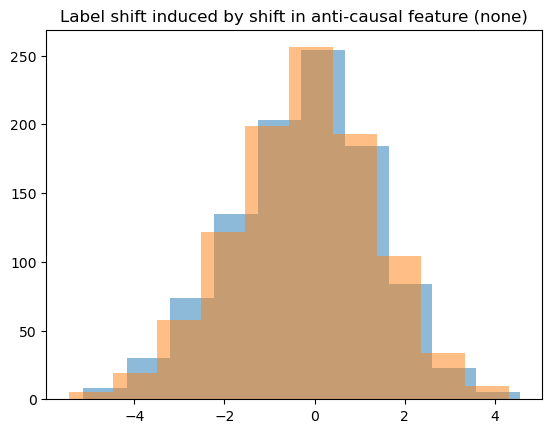

In [43]:
dataset = generate_test_samples(num_samples, adjacency, causal_mechanism, noise_generator, 
                                        shift_interventions={0:0,1:0,2:0,3:0,4:0,5:0,6:0})
labels = get_labels(dataset)
plt.hist(dataset[:,0],alpha=0.5)

dataset = generate_test_samples(num_samples, adjacency, causal_mechanism, noise_generator, 
                                        shift_interventions={0:0,1:0,2:10,3:0,4:0,5:0,6:0})
labels = get_labels(dataset)
plt.hist(dataset[:,0],color="tab:orange",alpha=0.5)
plt.title("Label shift induced by shift in anti-causal feature (none)")
plt.savefig('figures/exp/label_shift_anticausal.pdf')

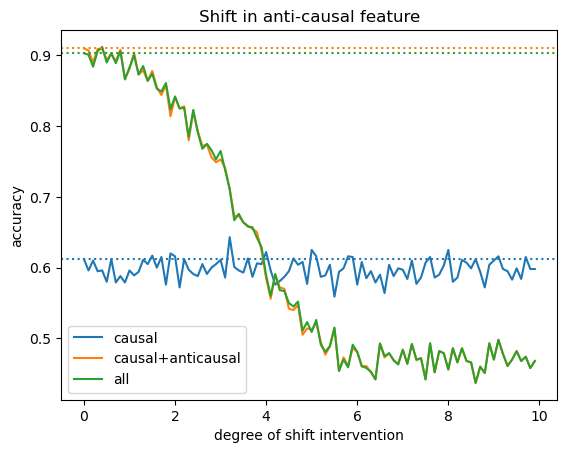

In [44]:
shift = np.arange(0,10,.1)
causal_ood_accuracy = np.array([ood_accuracy[0][round(item,1)][0]["causal"] for item in shift])
causal_anticausal_ood_accuracy = np.array([ood_accuracy[0][round(item,1)][0]["causal_anticausal"] for item in shift])
all_ood_accuracy = np.array([ood_accuracy[0][round(item,1)][0]["all"] for item in shift])
plt.title("Shift in anti-causal feature")

plt.plot(shift,causal_ood_accuracy, label="causal")

plt.plot(shift,causal_anticausal_ood_accuracy, label="causal+anticausal")

plt.plot(shift,all_ood_accuracy, label="all")

plt.axhline(ood_accuracy[0][0][0]["causal"], color='tab:blue',ls='dotted')
plt.axhline(ood_accuracy[0][0][0]["causal_anticausal"], color='tab:orange',ls='dotted')
plt.axhline(ood_accuracy[0][0][0]["all"], color='tab:green',ls='dotted')

plt.xlabel("degree of shift intervention")
plt.ylabel("accuracy")
plt.legend()
plt.savefig('figures/exp/anticausal.pdf')

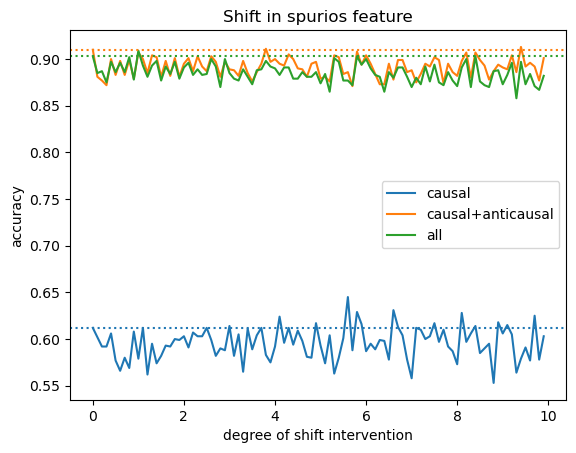

In [45]:
shift = np.arange(0,10,.1)
causal_ood_accuracy = np.array([ood_accuracy[0][0][round(item,1)]["causal"] for item in shift])
causal_anticausal_ood_accuracy = np.array([ood_accuracy[0][0][round(item,1)]["causal_anticausal"] for item in shift])
all_ood_accuracy = np.array([ood_accuracy[0][0][round(item,1)]["all"] for item in shift])
plt.title("Shift in spurios feature")
plt.plot(shift,causal_ood_accuracy, label="causal")

plt.plot(shift,causal_anticausal_ood_accuracy, label="causal+anticausal")

plt.plot(shift,all_ood_accuracy, label="all")

plt.axhline(ood_accuracy[0][0][0]["causal"], color='tab:blue',ls='dotted')
plt.axhline(ood_accuracy[0][0][0]["causal_anticausal"], color='tab:orange',ls='dotted')
plt.axhline(ood_accuracy[0][0][0]["all"], color='tab:green',ls='dotted')

plt.xlabel("degree of shift intervention")
plt.ylabel("accuracy")
plt.legend()

plt.savefig('figures/exp/spurios.pdf')

## Target shift

Generate synthetic experiments with different degree of target shift

In [46]:
ood_accuracy = {}
for target_shift in np.arange(0,10,.1):
    ood_accuracy[round(target_shift,1)] = {}
    dataset = generate_test_samples(num_samples, adjacency, causal_mechanism, noise_generator, 
                                        shift_interventions={0:target_shift,1:0,2:0,3:0,4:0,5:0,6:0})
    ood_test_labels = get_labels(dataset)
    ood_test_features = get_features(dataset)

    ood_test_pred = logistic_causal.predict(ood_test_features[:,0].reshape(-1, 1))
    ood_accuracy[round(target_shift,1)]["causal"] = accuracy_score(ood_test_labels, ood_test_pred)

    ood_test_pred = logistic_causal_anticausal.predict(ood_test_features[:,:2])
    ood_accuracy[round(target_shift,1)]["causal_anticausal"] = accuracy_score(ood_test_labels, ood_test_pred)

    ood_test_pred = logistic_all.predict(ood_test_features)
    ood_accuracy[round(target_shift,1)]["all"] = accuracy_score(ood_test_labels, ood_test_pred)


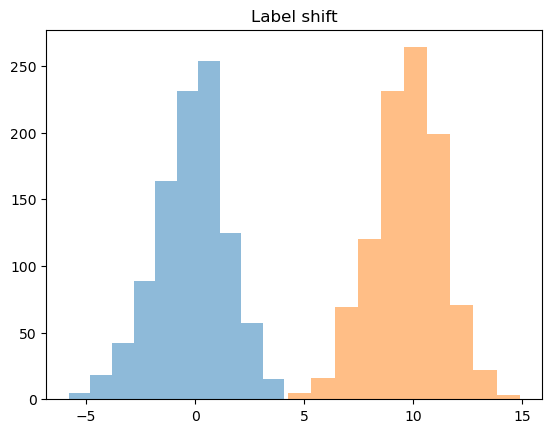

In [47]:
dataset = generate_test_samples(num_samples, adjacency, causal_mechanism, noise_generator, 
                                        shift_interventions={0:0,1:0,2:0,3:0,4:0,5:0,6:0})
labels = get_labels(dataset)
plt.hist(dataset[:,0],alpha=0.5)

dataset = generate_test_samples(num_samples, adjacency, causal_mechanism, noise_generator, 
                                        shift_interventions={0:10,1:0,2:0,3:0,4:0,5:0,6:0})
labels = get_labels(dataset)
plt.hist(dataset[:,0],color="tab:orange",alpha=0.5)
plt.title("Label shift")
plt.savefig('figures/exp/label_shift_hist.pdf')

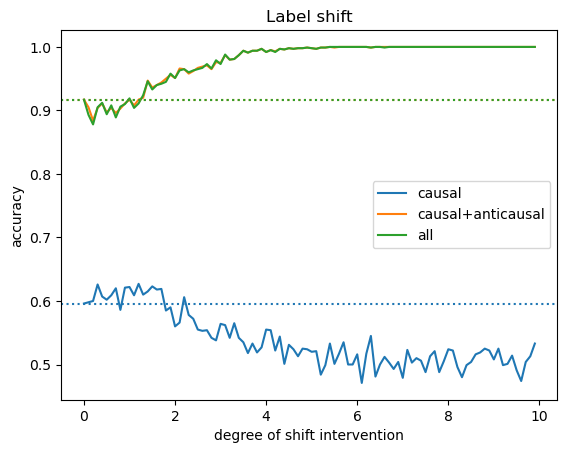

In [48]:
shift = np.arange(0,10,.1)
causal_ood_accuracy = np.array([ood_accuracy[round(item,1)]["causal"] for item in shift])
causal_anticausal_ood_accuracy = np.array([ood_accuracy[round(item,1)]["causal_anticausal"] for item in shift])
all_ood_accuracy = np.array([ood_accuracy[round(item,1)]["all"] for item in shift])
plt.title("Label shift")
plt.plot(shift,causal_ood_accuracy, label="causal")

plt.plot(shift,causal_anticausal_ood_accuracy, label="causal+anticausal")

plt.plot(shift,all_ood_accuracy, label="all")

plt.axhline(ood_accuracy[0]["causal"], color='tab:blue',ls='dotted')
plt.axhline(ood_accuracy[0]["causal_anticausal"], color='tab:orange',ls='dotted')
plt.axhline(ood_accuracy[0]["all"], color='tab:green',ls='dotted')

plt.xlabel("degree of shift intervention")
plt.ylabel("accuracy")
plt.legend()
plt.savefig('figures/exp/label_shift.pdf')

## Conditional shift

Generate synthetic experiments with different degree of conditional shift

In [49]:
def generate_ood(ood_accuracy,causal_shift,anti_causal_shift,spurios_shift):

    dataset = generate_test_samples(num_samples, adjacency, causal_mechanism, noise_generator, 
                                shift_interventions={0:0,1:0,2:0,3:0,4:causal_shift,5:anti_causal_shift,6:spurios_shift})
    ood_test_labels = get_labels(dataset)
    ood_test_features = get_features(dataset)


    ood_test_pred = logistic_causal.predict(ood_test_features[:,0].reshape(-1, 1))
    ood_accuracy[round(causal_shift,1)][round(anti_causal_shift,1)][round(spurios_shift,1)]["causal"] = accuracy_score(ood_test_labels, ood_test_pred)

    ood_test_pred = logistic_causal_anticausal.predict(ood_test_features[:,:2])
    ood_accuracy[round(causal_shift,1)][round(anti_causal_shift,1)][round(spurios_shift,1)]["causal_anticausal"] = accuracy_score(ood_test_labels, ood_test_pred)

    ood_test_pred = logistic_all.predict(ood_test_features)
    ood_accuracy[round(causal_shift,1)][round(anti_causal_shift,1)][round(spurios_shift,1)]["all"] = accuracy_score(ood_test_labels, ood_test_pred)

    return ood_accuracy

In [50]:
ood_accuracy = {}
for causal_shift in np.arange(0,10,.1):
    anti_causal_shift = 0
    spurios_shift = 0
    ood_accuracy[round(causal_shift,1)] = {}
    ood_accuracy[round(causal_shift,1)][round(anti_causal_shift,1)] = {}
    ood_accuracy[round(causal_shift,1)][round(anti_causal_shift,1)][round(spurios_shift,1)] = {}
    ood_accuracy = generate_ood(ood_accuracy,causal_shift,anti_causal_shift,spurios_shift)


for anti_causal_shift in np.arange(0,10,.1):
    causal_shift = 0
    spurios_shift = 0
    if anti_causal_shift > 0:
        ood_accuracy[round(causal_shift,1)][round(anti_causal_shift,1)] = {}
        ood_accuracy[round(causal_shift,1)][round(anti_causal_shift,1)][round(spurios_shift,1)] = {}
    ood_accuracy = generate_ood(ood_accuracy,causal_shift,anti_causal_shift,spurios_shift)

for spurios_shift in np.arange(0,10,.1):
    causal_shift = 0
    anti_causal_shift = 0
    if spurios_shift > 0:
        ood_accuracy[round(causal_shift,1)][round(anti_causal_shift,1)][round(spurios_shift,1)] = {}
    ood_accuracy = generate_ood(ood_accuracy,causal_shift,anti_causal_shift,spurios_shift)

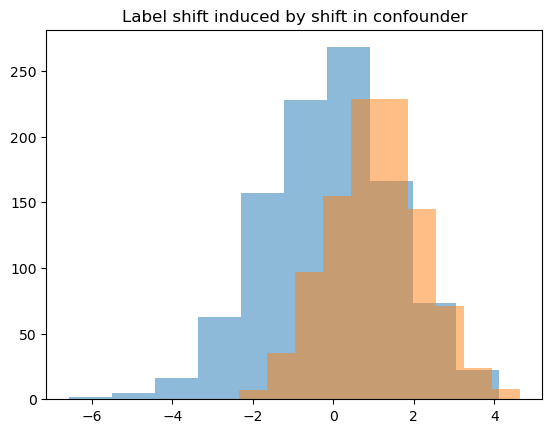

In [51]:
dataset = generate_test_samples(num_samples, adjacency, causal_mechanism, noise_generator, 
                                        shift_interventions={0:0,1:0,2:0,3:0,4:0,5:0,6:0})
labels = get_labels(dataset)
plt.hist(dataset[:,0],alpha=0.5)

dataset = generate_test_samples(num_samples, adjacency, causal_mechanism, noise_generator, 
                                        shift_interventions={0:0,1:10,2:0,3:0,4:0,5:0,6:0})
labels = get_labels(dataset)
plt.hist(dataset[:,0],color="tab:orange",alpha=0.5)
plt.title("Label shift induced by shift in confounder")
plt.savefig('figures/exp/confounder_label_shift.pdf')

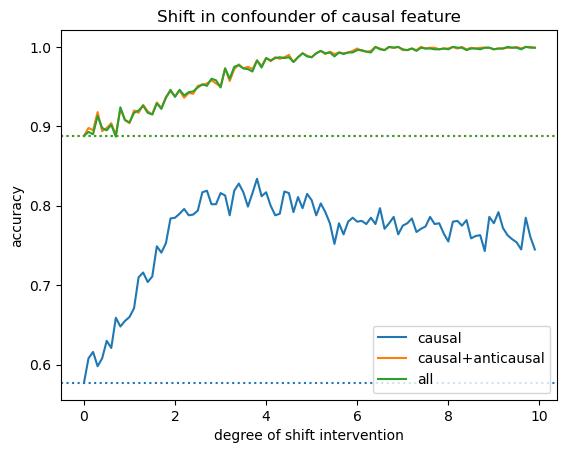

In [52]:
shift = np.arange(0,10,.1)
causal_ood_accuracy = np.array([ood_accuracy[round(item,1)][0][0]["causal"] for item in shift])
causal_anticausal_ood_accuracy = np.array([ood_accuracy[round(item,1)][0][0]["causal_anticausal"] for item in shift])
all_ood_accuracy = np.array([ood_accuracy[round(item,1)][0][0]["all"] for item in shift])
plt.title("Shift in confounder of causal feature")
plt.plot(shift,causal_ood_accuracy,label="causal")


plt.plot(shift,causal_anticausal_ood_accuracy, label="causal+anticausal")

plt.plot(shift,all_ood_accuracy, label="all")

plt.axhline(ood_accuracy[0][0][0]["causal"], color='tab:blue',ls='dotted')
plt.axhline(ood_accuracy[0][0][0]["causal_anticausal"], color='tab:orange',ls='dotted')
plt.axhline(ood_accuracy[0][0][0]["all"], color='tab:green',ls='dotted')

plt.xlabel("degree of shift intervention")
plt.ylabel("accuracy")
plt.legend()
plt.savefig('figures/exp/confounder_causal.pdf')

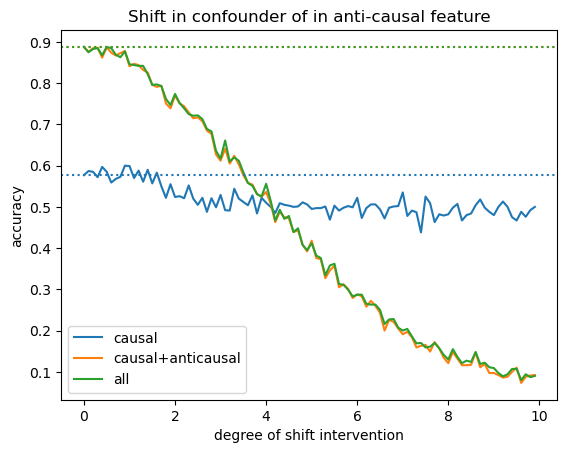

In [53]:
shift = np.arange(0,10,.1)
causal_ood_accuracy = np.array([ood_accuracy[0][round(item,1)][0]["causal"] for item in shift])
causal_anticausal_ood_accuracy = np.array([ood_accuracy[0][round(item,1)][0]["causal_anticausal"] for item in shift])
all_ood_accuracy = np.array([ood_accuracy[0][round(item,1)][0]["all"] for item in shift])
plt.title("Shift in confounder of in anti-causal feature")
plt.plot(shift,causal_ood_accuracy, label="causal")

plt.plot(shift,causal_anticausal_ood_accuracy, label="causal+anticausal")

plt.plot(shift,all_ood_accuracy, label="all")

plt.axhline(ood_accuracy[0][0][0]["causal"], color='tab:blue',ls='dotted')
plt.axhline(ood_accuracy[0][0][0]["causal_anticausal"], color='tab:orange',ls='dotted')
plt.axhline(ood_accuracy[0][0][0]["all"], color='tab:green',ls='dotted')

plt.xlabel("degree of shift intervention")
plt.ylabel("accuracy")
plt.legend()
plt.savefig('figures/exp/confounder_anticausal.pdf')

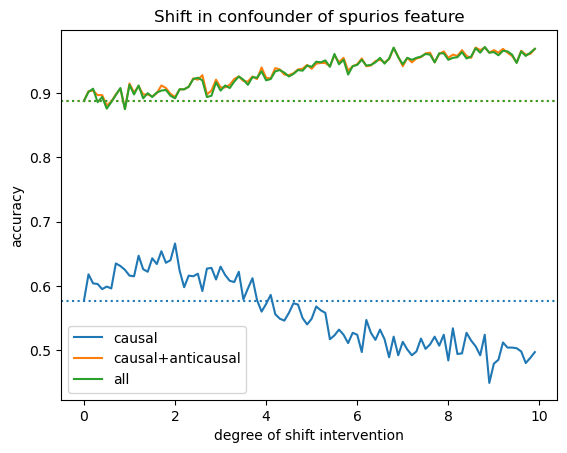

In [54]:
shift = np.arange(0,10,.1)
causal_ood_accuracy = np.array([ood_accuracy[0][0][round(item,1)]["causal"] for item in shift])
causal_anticausal_ood_accuracy = np.array([ood_accuracy[0][0][round(item,1)]["causal_anticausal"] for item in shift])
all_ood_accuracy = np.array([ood_accuracy[0][0][round(item,1)]["all"] for item in shift])
plt.title("Shift in confounder of spurios feature")
plt.plot(shift,causal_ood_accuracy, label="causal")

plt.plot(shift,causal_anticausal_ood_accuracy, label="causal+anticausal")

plt.plot(shift,all_ood_accuracy, label="all")

plt.axhline(ood_accuracy[0][0][0]["causal"], color='tab:blue',ls='dotted')
plt.axhline(ood_accuracy[0][0][0]["causal_anticausal"], color='tab:orange',ls='dotted')
plt.axhline(ood_accuracy[0][0][0]["all"], color='tab:green',ls='dotted')

plt.xlabel("degree of shift intervention")
plt.ylabel("accuracy")
plt.legend()

# print(logistic_all.coef_)
plt.savefig('figures/exp/confounder_spurios.pdf')